# Simulate MJP

In [393]:
import os
import sys
import torch
import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from tqdm import tqdm
from typing import Tuple,List

import os
import imageio
from IPython.display import Image
import numpy as np

from dataclasses import dataclass
from matplotlib import pyplot as plt

from torch.distributions import (
    Exponential,
    Categorical, 
    Dirichlet
)

# Utils

In [136]:
def create_gif_histograms(histograms0,
                          histograms1=None,
                          stationary_0=None,
                          stationary_1=None,
                          filenapath='histogram_animation.gif',
                          duration=1.):
    """
    List of histograms

    """
    # Generate the frames for the GIF
    if histograms1 is not None:
        assert histograms1.shape[1] == histograms0.shape[1]

    filenames = []
    for i, hist in enumerate(histograms0):
        plt.figure(figsize=(8, 6))

        # OLD
        plt.bar(range(len(hist)), hist, color='blue',alpha=0.3)
        if histograms1 is not None:
            hist1 = histograms1[i]
            plt.bar(range(len(hist1)), hist1, color='red',alpha=0.3)

        # NEW
        """
        fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(12, 3))

        stationary_0_ = stationary_0.squeeze().detach().numpy()
        stationary_1_ = stationary_1.squeeze().detach().numpy()

        axs[0].bar(range(len(hist0)), hist0, color='blue',alpha=0.3,label="sim")
        axs[0].bar(range(len( stationary_0_)), stationary_0_, color='green',alpha=0.3,label="exp")
        axs[0].set_ylim(0,1)
        axs[0].legend(loc="best")

        axs[1].bar(range(len(hist1)), hist1, color='red',alpha=0.3,label="sim")
        axs[1].bar(range(len( stationary_1_)), stationary_1_,color='green',alpha=0.3,label="exp")
        axs[1].set_ylim(0,1)
        axs[1].legend(loc="best")
        plt.show()
        """

        plt.title(f'Normalized Histogram - Frame {i+1}')
        plt.ylim(0, 1)  # Ensure consistent scale across all frames

        # Save each frame to a file
        filename = f'hist_frame_{i}.png'
        plt.savefig(filename)
        plt.close()
        filenames.append(filename)

    # Create a GIF from the frames
    with imageio.get_writer(filenapath, mode='I', duration=duration) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)

    # Optionally clean up the individual frame files
    for filename in filenames:
        os.remove(filename)

    # Display the GIF in the Jupyter Notebook
    Image(filename=filenapath)

In [3]:
def states_at_grid(paths_batch, times, time_grid):
    """
    For a simulation of states and times, for each value of the time grid,
    assigns the state with the rightmost time to the grid time.

    :param times: torch.Tensor(batch_size,number_of_timesteps)
    :param paths_batch torch.Tensor(batch_size,number_of_timesteps,number_of_spins):
    :param time_grid: torch.Tensor(number_of_timesteps)
    :return:
    """
    if len(times.shape) == 3:
        times = times.squeeze()

    assert torch.all(times[:, 0] == 0.)
    assert time_grid[0] == 0.
    assert paths_batch.shape[:-1] == times.shape

    batch_size = paths_batch.shape[0]
    tau = time_grid[1]
    time_grid_ = time_grid + tau # arrival is to the left of the box

    x = time_grid_[None, None, :] - times[:, :, None]
    times_not_allowed = times[:, :, None] > time_grid_[None, None, :]
    x[times_not_allowed] = torch.inf
    min_indices = torch.argmin(x, axis=1)

    arrivals = times[torch.arange(batch_size)[:, None], min_indices]
    states_at_arrival = paths_batch[torch.arange(batch_size)[:, None], min_indices, :]

    return states_at_arrival,arrivals

In [4]:
def choose_new_states(new_states_available,which_state_to_take):
    """
    selects from available according to which_state_to_take 

    parameters
    ----------
    new_states_available: (number_of_paths,dimension,number_of_new_possible)
    which_state_to_take :(number_of_paths) \in [0,number_of_new_possible]

    returns
    -------
    new_states: (number_of_paths,dimension)
    """
    # Assuming N, D, and number_of_states are defined
    N = new_states_available.size(0)  # example value
    D = new_states_available.size(1)   # example value
    # To use selected_index to index X, we need to unsqueeze it to make it broadcastable
    which_state_to_take = which_state_to_take.unsqueeze(-1).expand(N, D)  # Shape (N, D)
    # Now, gather the elements. We want to gather along the last dimension
    new_states = torch.gather(new_states_available, 2, which_state_to_take.unsqueeze(2)).squeeze(2)  # Use unsqueeze to match the gather requirement and squeeze to drop the extra dimension
    
    return new_states

In [5]:
def count_values_along_time(paths, num_states):
    """
    Count each integer's occurrences at each timestep along the second dimension of a tensor.

    Parameters:
        paths (torch.Tensor): A 2D tensor of shape (N, T) containing integer values.
        num_states (int): The number of distinct states (integer values).

    Returns:
        torch.Tensor: A 2D tensor of shape (T, num_states) where each row gives the counts
                      of each state at that timestep.
    """
    N, T = paths.shape
    counts = torch.zeros((T, num_states), dtype=torch.long)

    # Process each timestep
    for t in range(T):
        # Extract the data at timestep t
        timestep_data = paths[:, t]
        # Count occurrences of each state at this timestep
        for state in range(num_states):
            counts[t, state] = torch.sum(timestep_data == state)

    return counts

# Find Q

In [306]:
import torch
from torch import nn
import torch.optim as optim

class TrainableQ(nn.Module):
    def __init__(self, size, rate):
        super(TrainableQ, self).__init__()
        self.size = size
        self.rate = rate
        
        # Compute indices for off-diagonal elements
        rows, cols = torch.triu_indices(size, size, offset=1)
        indexes = torch.arange(0,size,1)

        self.register_buffer('row_indices', rows)
        self.register_buffer('col_indices', cols)
        self.register_buffer('indexes',indexes)
        
        # Initialize off-diagonal elements as trainable parameters from an exponential distribution
        initial_values = torch.distributions.Exponential(rate).sample((rows.size(0) * 2,))
        self.off_diagonal_elements = nn.Parameter(initial_values)

    def forward(self):
        # Initialize a zero matrix
        matrix = torch.zeros(self.size, self.size, device=self.off_diagonal_elements.device)
        
        # Apply relu to ensure off-diagonal elements are positive
        positive_off_diagonals = torch.relu(self.off_diagonal_elements) + 1e-2

        # Fill the off-diagonal elements
        matrix[self.row_indices, self.col_indices] = positive_off_diagonals[:self.row_indices.size(0)]
        matrix[self.col_indices, self.row_indices] = positive_off_diagonals[self.row_indices.size(0):]
        
        # Fill the diagonal
        matrix[self.indexes, self.indexes] = -matrix.sum(axis=1)
        return matrix

def obtain_Q(pi_0,lambda_ = 1.,num_epochs = 5000,lr=0.05,verbose=False):
    pi_0 = pi_0.squeeze()
    N = pi_0.shape[0]
    pi_0 = pi_0.unsqueeze(0)

    Q =  TrainableQ(N,lambda_)
    # Setup optimizer
    optimizer = optim.Adam(Q.parameters(), lr=lr)
    zeros = torch.zeros(N)  # Target is a zero vector
    # Training loop
    
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        
        # Forward pass
        matrix = Q()
        output = torch.matmul(pi_0,matrix)
        
        # Compute loss (MSE Loss)
        loss = torch.nn.functional.mse_loss(output, zeros)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        if verbose:
            if epoch % 100 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item()}')

    return Q().detach()

def rescale_time(Q0,times_in_one=100.):
    N = Q0.shape[0]
    R0 = Q0.clone()
    R0[range(N),range(N)] = torch.zeros(N,)
    min_r0 = R0.sum(axis=1).min()
    scale_0 = times_in_one/min_r0
    Q0 = Q0*scale_0
    return Q0

# SOLVERS

In [412]:
def gillespie(X0,Q,T=1.,max_iter=100)->Tuple[torch.Tensor,torch.Tensor]:
    """
    # http://be150.caltech.edu/2019/handouts/12_stochastic_simulation_all_code.html

    parameters
    ----------

    X0: initial conditions
    q_rate_function: function -> new_states_available,rates

    returns
    -------
    paths,times
    """
    num_states = Q.size(0)
    batch_size = X0.shape[0]

    rates_from_Q  = lambda X,Q : Q[X]
    Q_r = Q.clone()
    Q_r[range(num_states),range(num_states)] = 0

    # Initialize process
    times = torch.full((batch_size, 1), 0.)
    paths = X0.unsqueeze(1)

    iter = 0
    while torch.any(times[:,-1] < T):
        X = paths[:,-1]
        current_time = times[:,-1]

        # rates and probabilities
        rates = rates_from_Q(X, Q_r)
        rates_sum = -Q[X,X].squeeze() #diagonal sum to 0
        transition_probabilities = rates/rates_sum[:,None]

        #times
        time_between_events = Exponential(rates_sum).sample()
        new_times = current_time + time_between_events

        # selects next state
        new_states = Categorical(transition_probabilities).sample()

        #update paths and times
        paths = torch.concatenate([paths,
                                   new_states.unsqueeze(1)], dim=1)

        times = torch.concatenate([times,
                                   new_times.unsqueeze(1)],dim=1)
        
        iter+=1
        if iter > max_iter:
            break
    return paths,times

# Simulate Q

In [307]:
N = 3
alpha = 0.2
dirichlet_alpha = torch.full((N,),alpha)
stationary_0 = Dirichlet(dirichlet_alpha).sample((1,)).T
stationary_1 = Dirichlet(dirichlet_alpha).sample((1,)).T

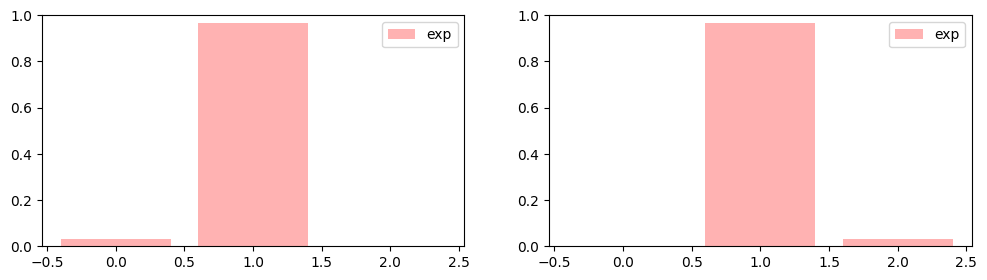

In [387]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(12, 3))

#stationary_1 = stationary_0.flip(dims=[0])
#stationary_0 = stationary_1.flip(dims=[0])

stationary_0_ = stationary_0.squeeze().detach().numpy()
stationary_1_ = stationary_1.squeeze().detach().numpy()

axs[0].bar(range(len( stationary_0_)), stationary_0_, color='red',alpha=0.3,label="exp")
axs[0].set_ylim(0,1)
axs[0].legend(loc="best")

axs[1].bar(range(len( stationary_1_)), stationary_1_,color='red',alpha=0.3,label="exp")
axs[1].set_ylim(0,1)
axs[1].legend(loc="best")
plt.show()

In [406]:
Q0 = obtain_Q(stationary_0.T,lambda_ = 1.,num_epochs=5000,lr=0.1)
Q1 = obtain_Q(stationary_1.T,lambda_ = 1.,num_epochs=5000,lr=0.05)

Q0_= Q0
Q1_= Q1

print(torch.matmul(stationary_0.T,Q0))
print(torch.matmul(stationary_1.T,Q1))

C:\Users\cesar\AppData\Local\Temp\ipykernel_7588\2805406258.py:57: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch.nn.functional.mse_loss(output, zeros)


tensor([[-2.8143e-09, -1.3923e-09,  5.6940e-09]])
tensor([[-2.0923e-10,  8.1165e-10,  1.9931e-10]])


In [355]:
Q0_= rescale_time(Q0,times_in_one=1500.)
Q1_= rescale_time(Q1,times_in_one=1500.)

print(torch.matmul(stationary_0.T,Q0_))
print(torch.matmul(stationary_1.T,Q1_))

tensor([[ 3.4547e-05,  8.0137e-05, -8.1965e-05]])
tensor([[-1.8116e-05,  1.7166e-04, -2.2529e-05]])


In [408]:
number_of_paths = 400 
number_of_times = 100
N = Q0.shape[0]

pi_0 = torch.ones((N,))/N
alpha_prior = torch.full((N,),0.1)
pi_0 = Dirichlet(alpha_prior).sample((1,)).squeeze()

X0 = Categorical(torch.Tensor(stationary_0.squeeze())).sample((number_of_paths,))

In [424]:
T = 10000.
paths0,times0 = gillespie(X0,Q0_,T=T)
paths1,times1 = gillespie(X0,Q1_,T=T)

In [425]:
times0.shape

torch.Size([400, 102])

In [426]:
times1.shape

torch.Size([400, 102])

In [427]:
# set everything in a grid
time_grid = torch.linspace(0.,T,number_of_times)
paths0_grid,arrivals0 = states_at_grid(paths0.unsqueeze(-1), times0, time_grid)
paths1_grid,arrivals1 = states_at_grid(paths1.unsqueeze(-1), times1, time_grid)

paths0_grid = paths0_grid.squeeze()
paths1_grid = paths1_grid.squeeze()

histograms_on_time_0 = count_values_along_time(paths0_grid, N)
histograms_on_time_1 = count_values_along_time(paths1_grid, N)

histograms_on_time_0 = histograms_on_time_0/paths0_grid.shape[0]
histograms_on_time_1 = histograms_on_time_1/paths1_grid.shape[0]

In [453]:
time_index = 1

hist0 = F.one_hot(paths0[:,time_index],N).sum(axis=0)
hist0 = hist0/paths0.shape[0]

hist1 = F.one_hot(paths1[:,time_index],N).sum(axis=0)
hist1 = hist1/paths1.shape[0]

print(hist0)
print(hist0.sum())
print(hist1)
print(hist1.sum())

tensor([0.4350, 0.0275, 0.5375])
tensor(1.)
tensor([0.4675, 0.0275, 0.5050])
tensor(1.)


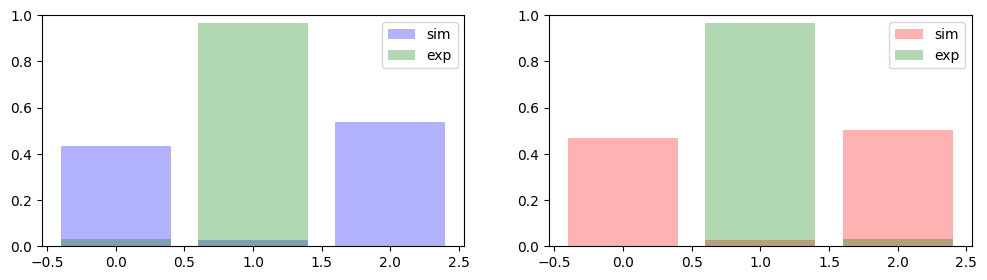

In [454]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(12, 3))

stationary_0_ = stationary_0.squeeze().detach().numpy()
stationary_1_ = stationary_1.squeeze().detach().numpy()

axs[0].bar(range(len(hist0)), hist0, color='blue',alpha=0.3,label="sim")
axs[0].bar(range(len( stationary_0_)), stationary_0_, color='green',alpha=0.3,label="exp")
axs[0].set_ylim(0,1)
axs[0].legend(loc="best")

axs[1].bar(range(len(hist1)), hist1, color='red',alpha=0.3,label="sim")
axs[1].bar(range(len( stationary_1_)), stationary_1_,color='green',alpha=0.3,label="exp")
axs[1].set_ylim(0,1)
axs[1].legend(loc="best")
plt.show()

In [458]:
Q0

tensor([[-0.3252,  0.3152,  0.0100],
        [ 0.0100, -0.0200,  0.0100],
        [ 0.0100,  3.2367, -3.2467]])

In [372]:
hist0

tensor([0.0275, 0.9675, 0.0050])

In [366]:
list(range(len(hist1)))

[0, 1, 2]

In [363]:
stationary_0

tensor([[0.0298],
        [0.9671],
        [0.0031]])

In [364]:
stationary_1

tensor([[0.0031],
        [0.9671],
        [0.0298]])

In [151]:
create_gif_histograms(histograms_on_time_0,histograms_on_time_1)

C:\Users\cesar\AppData\Local\Temp\ipykernel_7588\786166944.py:56: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [ ]:
print(histograms_on_time_0[-1])
print(histograms_on_time_1[-1])

tensor([0.0000, 0.2767, 0.5267, 0.0000, 0.1967])
tensor([0.0067, 0.3300, 0.2000, 0.0933, 0.3700])


In [ ]:
print(histograms_on_time_0[0])
print(histograms_on_time_1[0])

tensor([0.2133, 0.0633, 0.2133, 0.2667, 0.2433])
tensor([0.2333, 0.1267, 0.0467, 0.2700, 0.3233])


# OPTIMAL TRANSPORT

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ot  # Import Python Optimal Transport library

In [ ]:
def solve_regularized_transport(histogram_a,histogram_b):
    # Setting up the distributions
    # Uniform distribution of 10 points from 0 to 1
    n_points = histogram_a.shape[0]

    # Generate positions for each point in the distributions
    x = np.linspace(0, 1, n_points).reshape(-1, 1)  # Positions for a
    y = np.linspace(0, 1, n_points).reshape(-1, 1)  # Positions for b

    # Cost matrix: Euclidean distance
    C = ot.dist(x, y)
    C = C / C.max()  # Normalize cost for stability

    # Regularization parameter
    lambda_reg = 0.1  # Small lambda means more regularization

    # Solve the regularized optimal transport problem using Sinkhorn algorithm
    P = ot.sinkhorn(histogram_a, histogram_b, C, lambda_reg,numItermax=1000)

    # Compute the actual transport distance
    transport_distance = np.sum(P * C)  # Dot product of P and C
    
    return C,P,transport_distance

In [ ]:
def get_trasport_over_time(histograms_on_time_0,histograms_on_time_1):
    number_of_time_steps = histograms_on_time_0.shape[0]
    transport_cost_over_time = torch.zeros(number_of_time_steps)

    for time_index in range(number_of_time_steps):
        histogram_a = histograms_on_time_0[time_index].numpy()
        histogram_b = histograms_on_time_1[time_index].numpy()
        C,P,transport_distance = solve_regularized_transport(histogram_a,histogram_b)
        transport_cost_over_time[time_index] = transport_distance

    return transport_cost_over_time

In [ ]:
d_param = DirichletPriorOnRatesParam(concentration=0.01)
Q0 = generate_transition_rate_matrix(d_param)
Q1 = generate_transition_rate_matrix(d_param)
X0 = torch.randint(1,d_param.num_states,(300,))
TAU = np.linspace(0.,1.,10)

time_grid = torch.arange(0,101,1,dtype=float)
paths0,times0 = gillespie(X0,Q0,number_of_times=100)
paths0_grid,arrivals0 = states_at_grid(paths1.unsqueeze(-1), times0, time_grid)
paths0_grid = paths0_grid.squeeze()
histograms_on_time_0 = count_values_along_time(paths0_grid, d_param.num_states)
number_of_time_steps = histograms_on_time_0.shape[0]

for tau in TAU:
    print(f"Tau: {tau}")
    Q_tau = interpolation_tau*Q0 + (1.-interpolation_tau)*Q1
    paths1,times1 = gillespie(X0,Q_tau,number_of_times=100)

    # set everything in a grid
    paths1_grid,arrivals1 = states_at_grid(paths1.unsqueeze(-1), times0, time_grid)
    paths1_grid = paths1_grid.squeeze()

    histograms_on_time_1 = count_values_along_time(paths1_grid, d_param.num_states)
    histograms_on_time_1 = histograms_on_time_1/paths1_grid.shape[0]

    transport_over_time = get_trasport_over_time(histograms_on_time_0,histograms_on_time_1)
    print(transport_over_time.mean())

Tau: 0.0


c:\Users\cesar\anaconda4\envs\rate_matching\lib\site-packages\ot\bregman\_sinkhorn.py:499: RuntimeWarning: overflow encountered in divide
  u = 1. / nx.dot(Kp, v)
c:\Users\cesar\anaconda4\envs\rate_matching\lib\site-packages\ot\bregman\_sinkhorn.py:506: UserWarning: Warning: numerical errors at iteration 124
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


tensor(13.7929)
Tau: 0.1111111111111111
tensor(13.8747)
Tau: 0.2222222222222222
tensor(13.6804)
Tau: 0.3333333333333333
tensor(13.9385)
Tau: 0.4444444444444444
tensor(13.9176)
Tau: 0.5555555555555556
tensor(13.7662)
Tau: 0.6666666666666666
tensor(13.8569)
Tau: 0.7777777777777777
tensor(13.6817)
Tau: 0.8888888888888888
tensor(14.0167)
Tau: 1.0
tensor(13.8706)


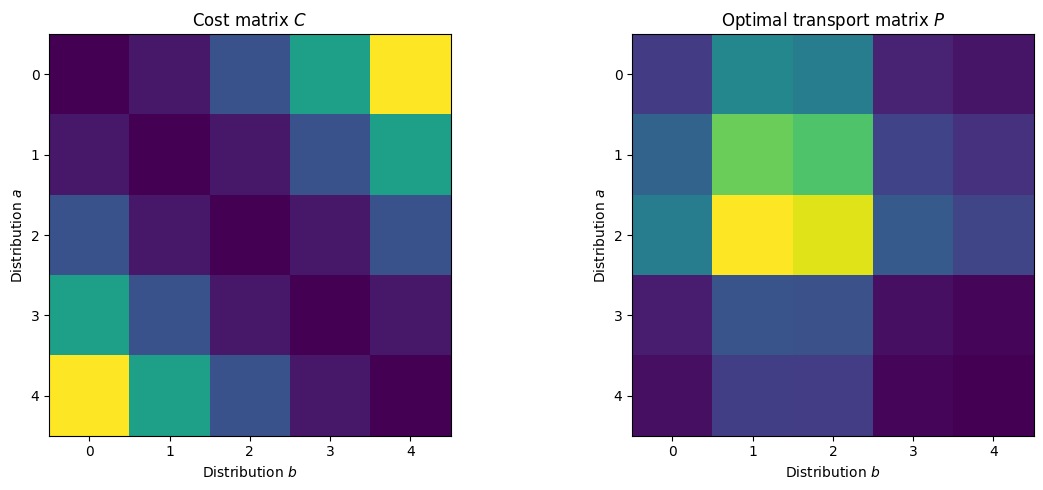

In [ ]:
# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot cost matrix
ax[0].imshow(C, interpolation='nearest')
ax[0].set_title('Cost matrix $C$')
ax[0].set_xlabel('Distribution $b$')
ax[0].set_ylabel('Distribution $a$')

# Plot optimal transport matrix
ax[1].imshow(P, interpolation='nearest')
ax[1].set_title('Optimal transport matrix $P$')
ax[1].set_xlabel('Distribution $b$')
ax[1].set_ylabel('Distribution $a$')

plt.tight_layout()
plt.show()